# 机器学习纳米学位   
猫狗大战毕业项目   
张斌   
2019年2月1日

## 项目说明
使用深度学习方法识别一张图片是猫还是狗，属于二分类问题。输出结果为概率，越接近1表示分类结果是猫的可能性越大，越接近0表示分类结果是狗的可能性越大。
- 输入：一张彩色图片
- 输出：是猫的概率，如果概率太低说是狗。

## 实验环境
项目使用Anaconda搭建环境。使用environment目录下的yml进行环境安装。   

$ conda env create -f environmert.yml   

## 数据探索及预处理

从 [Dogs vs. Cats Redux: Kernels Edition](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data) 下载并解压训练数据到`data`目录。   
数据集由训练数据和测试数据组成，训练数据包含猫和狗各12500张图片，测试数据包含12500张猫和狗的图片。

## 导入库

In [1]:
from PIL import Image
import os
import numpy as np
# 提供文件和文件集合的高级操作，复制、删除等
import shutil
# 导入计数
from collections import Counter
# 文件操作模块
from glob import glob
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input as preprocess_input_ResNet50
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input as preprocess_input_Xception
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as preprocess_input_InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import  Dense, Dropout
from keras.callbacks import ModelCheckpoint 
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.utils import np_utils
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline 


Using TensorFlow backend.


## 加载图片数据

In [2]:
# train 中的数据
train_files = glob("data/train/*")
train_files = np.array(train_files)

In [3]:
# test 中的数据
test_files = glob("data/test/*")
test_files = np.array(test_files)

## 剔除异常值   
对`train`中所有的图片进行图像直方图分析，对图片中包含的色彩与图片的像素的比值进行分析，此次利用箱型图原理，显示一组数据分散情况，箱形图为我们提供了识别异常值的一个标准：异常值被定义为小于Q1－1.5IQR或大于Q3+1.5IQR的值，从而筛选出异常值，并剔除。

In [4]:
# 利用直方图，计算图片中的色彩与图片像素的比值函数
def calhistogram(file):
    # 打开图片
    img = Image.open(file)
    # 直方图
    his = img.histogram()
    # 计算色彩的数量
    count = Counter(his)
    # 计算色彩数量和图片像素的比值
    return float(len(count))/len(his)

In [5]:
# 建立所有图片色彩和图片像素的比值的list
color_pixel_ratio_list = []
for train_file in train_files:
    color_pixel_ratio_list.append(calhistogram(train_file))

In [6]:
# 创建图片色彩和图片像素的比值和图片地址的dict
color_pixel_dict = dict(zip(color_pixel_ratio_list,train_files))

识别异常值的一个标准：异常值被定义为小于Q1－1.5IQR或大于Q3+1.5IQR的值,计算出项目中的两个点。    
利用`np.percentile`方法，返回第q个百分位数，两个异常值判断点分别如下：

In [7]:
# 第一四分位数
Q1 = np.percentile(color_pixel_ratio_list, [25])
# 第三四分位数
Q3 = np.percentile(color_pixel_ratio_list, [75])
# 四分位距IQR
IQR = Q3 - Q1

# 异常值1
abnormal_1 = Q1 - 1.5 * IQR
# 异常值2
abnormal_2 = Q3 + 1.5 * IQR

print(abnormal_1, abnormal_2)

[ 0.35221354] [ 0.94075521]


### 筛选出异常的图片

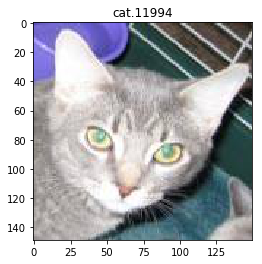

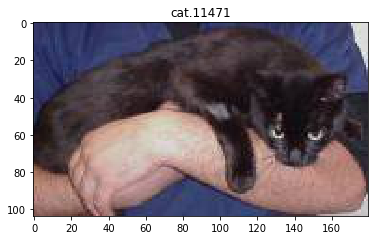

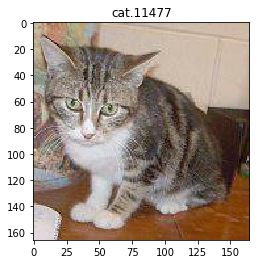

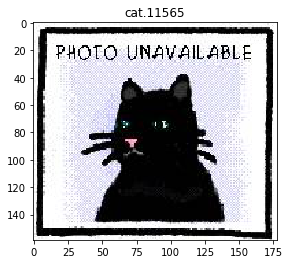

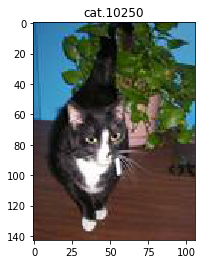

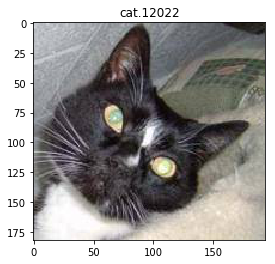

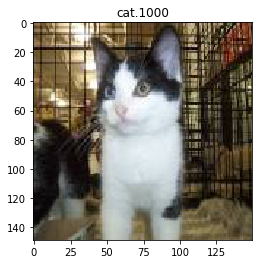

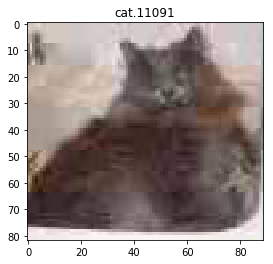

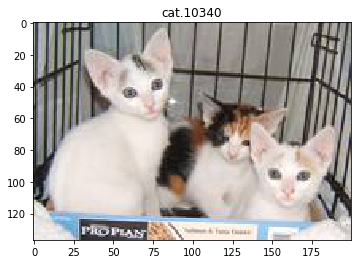

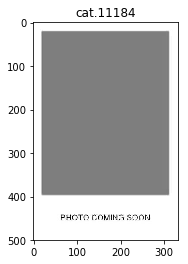

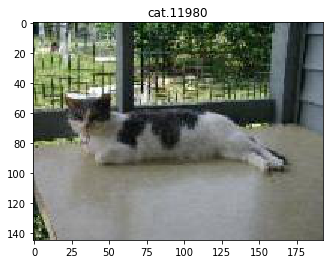

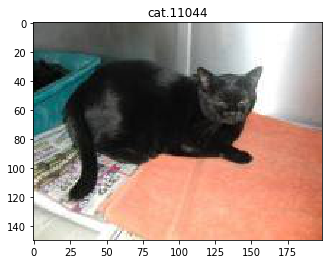

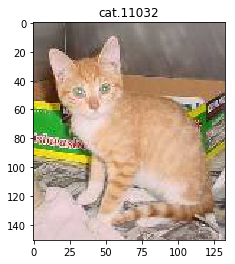

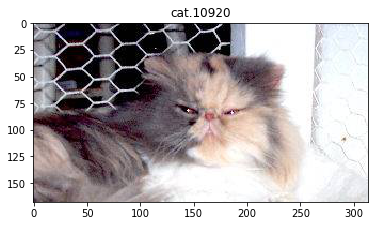

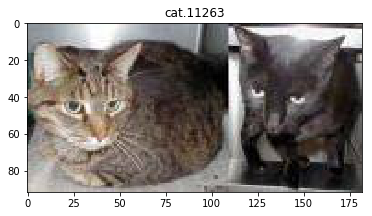

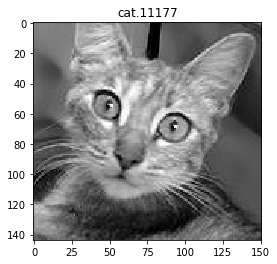

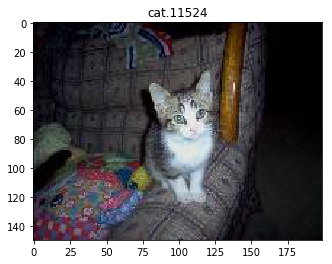

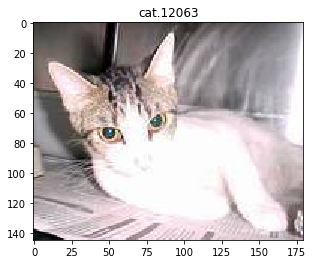

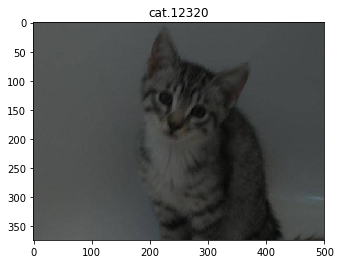

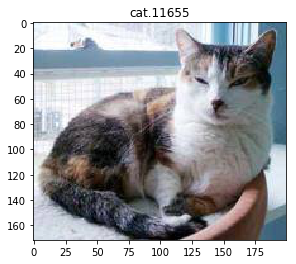

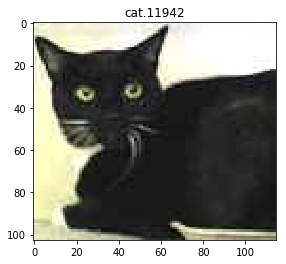

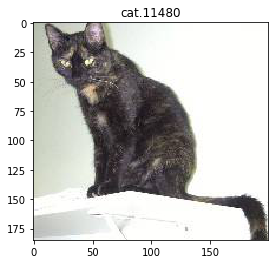

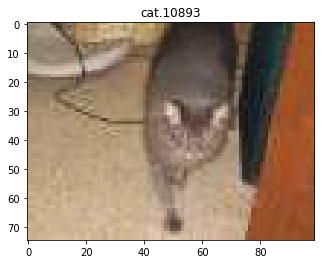

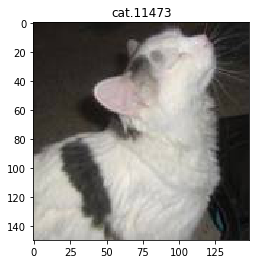

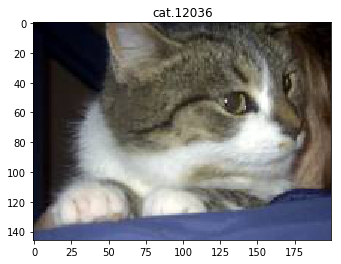

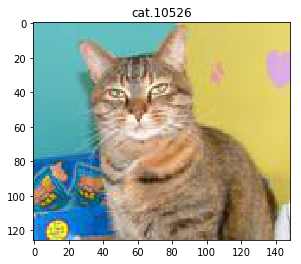

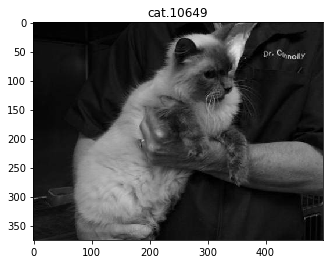

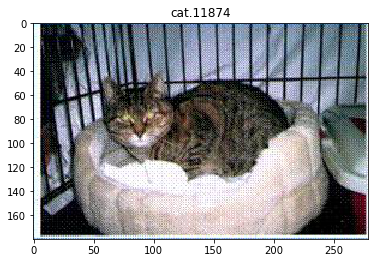

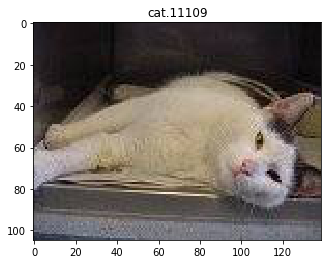

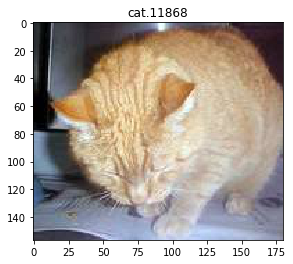

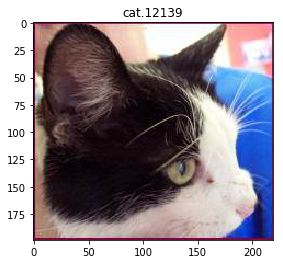

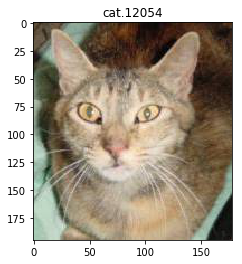

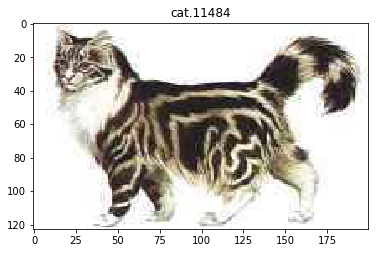

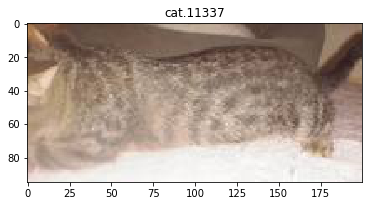

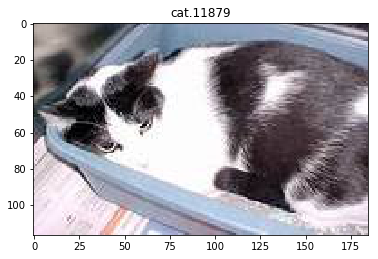

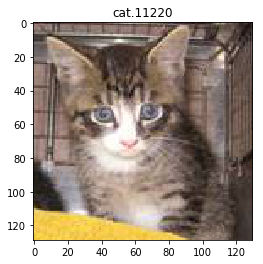

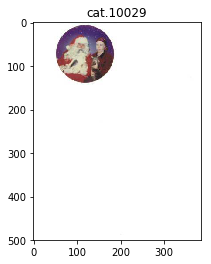

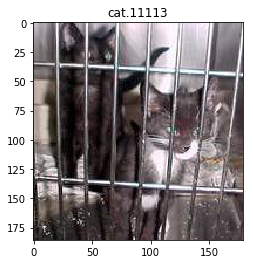

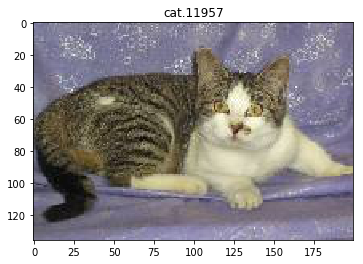

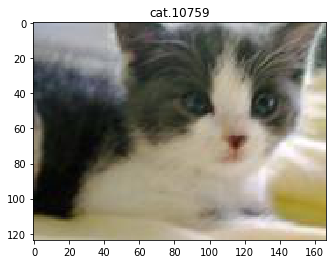

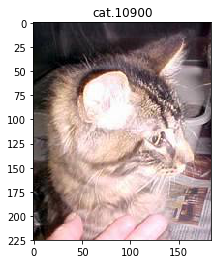

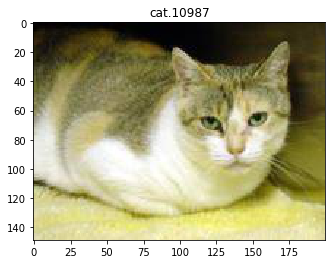

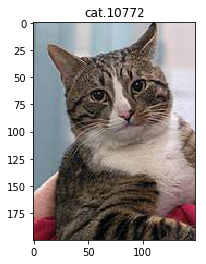

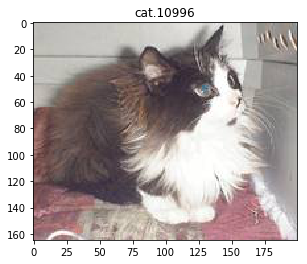

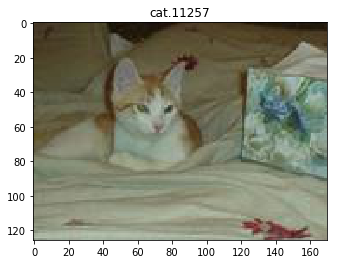

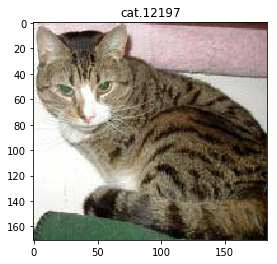

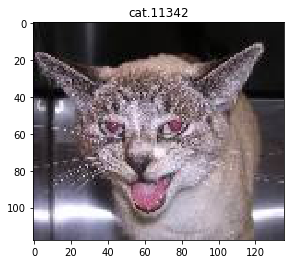

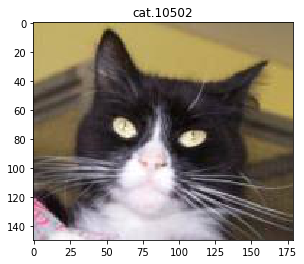

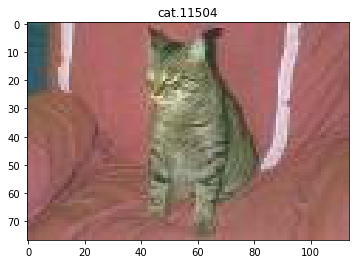

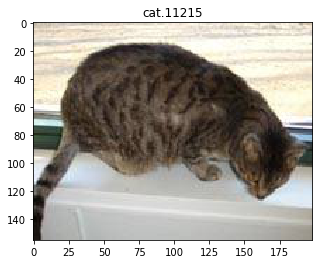

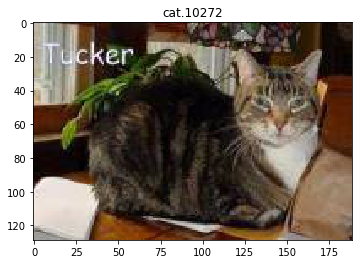

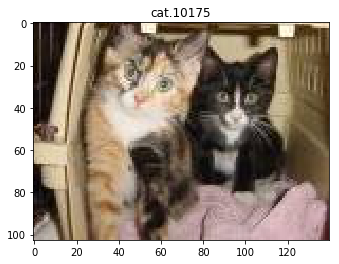

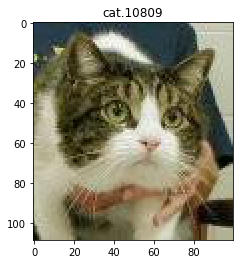

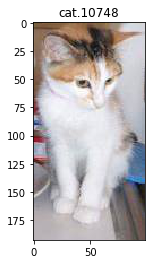

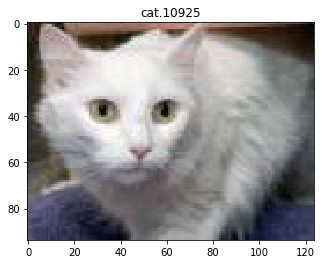

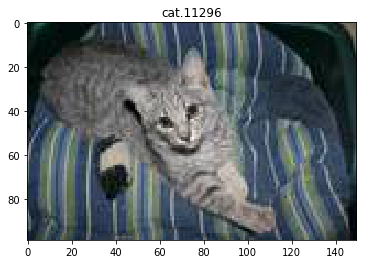

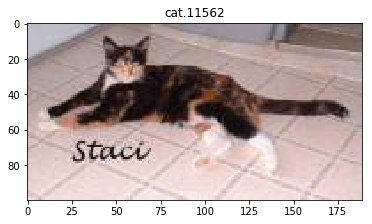

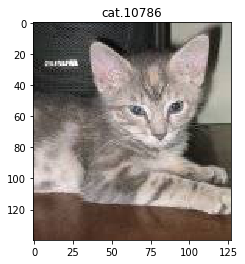

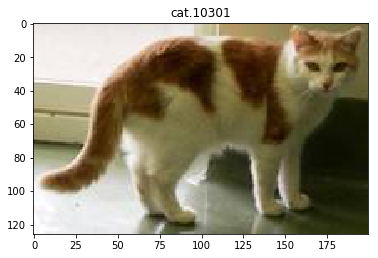

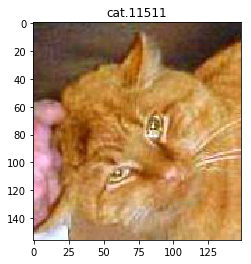

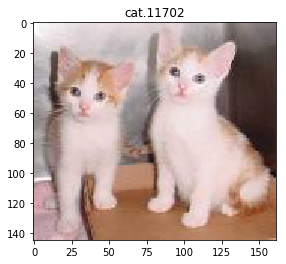

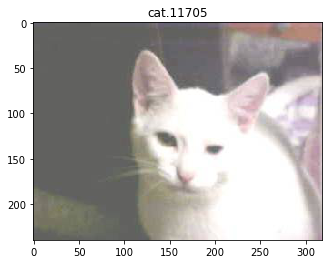

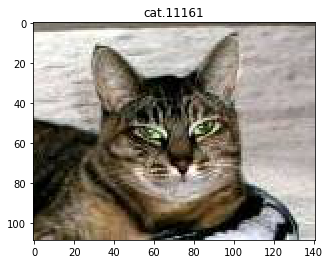

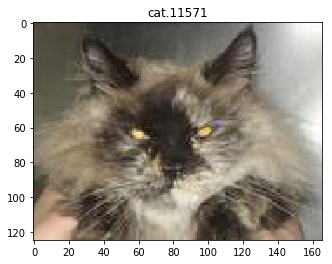

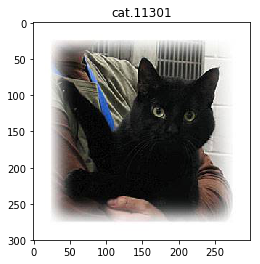

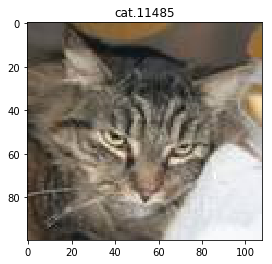

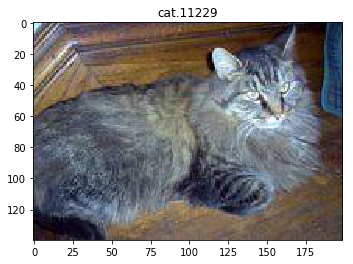

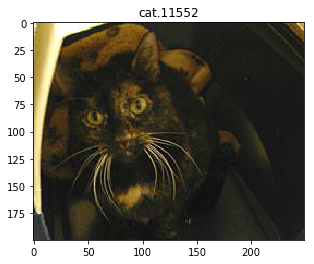

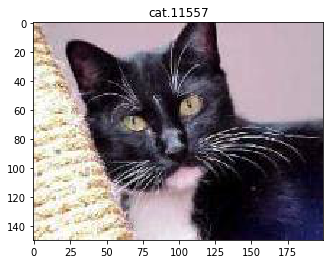

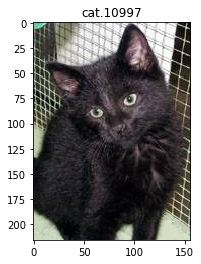

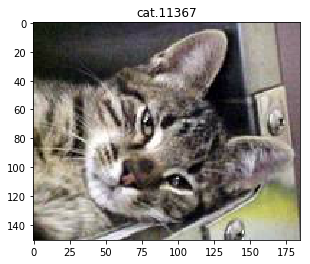

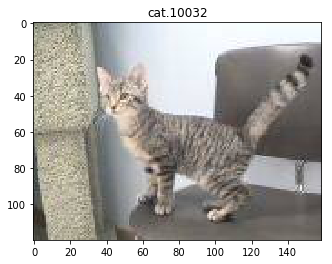

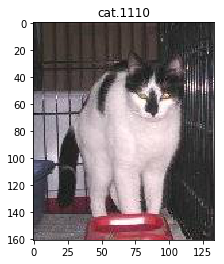

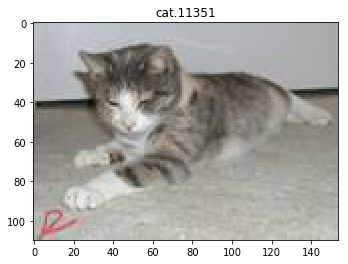

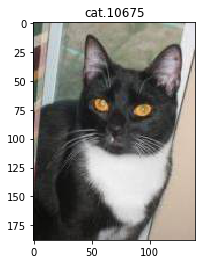

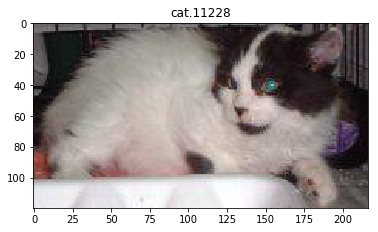

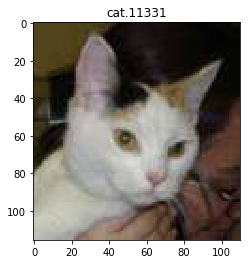

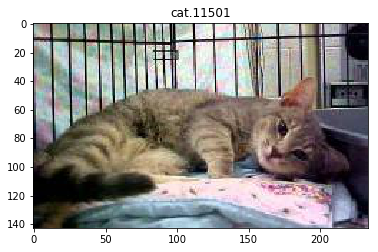

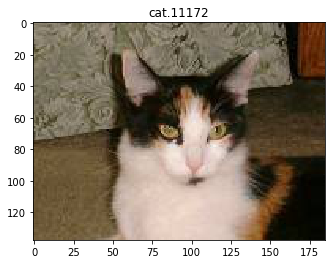

['data/train\\cat.11994.jpg', 'data/train\\cat.11471.jpg', 'data/train\\cat.11477.jpg', 'data/train\\cat.11565.jpg', 'data/train\\cat.10250.jpg', 'data/train\\cat.12022.jpg', 'data/train\\cat.1000.jpg', 'data/train\\cat.11091.jpg', 'data/train\\cat.10340.jpg', 'data/train\\cat.11184.jpg', 'data/train\\cat.11980.jpg', 'data/train\\cat.11044.jpg', 'data/train\\cat.11032.jpg', 'data/train\\cat.10920.jpg', 'data/train\\cat.11263.jpg', 'data/train\\cat.11177.jpg', 'data/train\\cat.11524.jpg', 'data/train\\cat.12063.jpg', 'data/train\\cat.12320.jpg', 'data/train\\cat.11655.jpg', 'data/train\\cat.11942.jpg', 'data/train\\cat.11480.jpg', 'data/train\\cat.10893.jpg', 'data/train\\cat.11473.jpg', 'data/train\\cat.12036.jpg', 'data/train\\cat.10526.jpg', 'data/train\\cat.10649.jpg', 'data/train\\cat.11874.jpg', 'data/train\\cat.11109.jpg', 'data/train\\cat.11868.jpg', 'data/train\\cat.12139.jpg', 'data/train\\cat.12054.jpg', 'data/train\\cat.11484.jpg', 'data/train\\cat.11337.jpg', 'data/train\\c

In [8]:
# 异常图片list
abnormal_pic_list = []
for key, value in color_pixel_dict.items():
    # 判断小于异常值
    if key < abnormal_1:
        # 加入异常pic列表中
        abnormal_pic_list.append(value)
        # 打开异常pic，并展示
        abnormal_img = Image.open(value) 
        # 异常图片名称
        plt.title(value[11:-4])
        plt.imshow(abnormal_img)
        plt.show()
        
    # 判断大于异常值
    if key > abnormal_2:
        # 加入异常pic列表中
        abnormal_pic_list.append(value)
        # 打开异常pic，并展示
        abnormal_img = Image.open(value) 
        # 异常图片名称
        plt.title(value[11:-4])
        plt.imshow(abnormal_img)
        plt.show()
        
# 输出所有异常picture        
print(abnormal_pic_list)

### 建立新建文件夹函数，将异常的图片剪切到新的文件夹中。

In [9]:
# 新建文件夹，如有重名删除原文件夹
def create_folder(dirname):
    # 判断dirname文件是否存在
    if os.path.exists(dirname):
        # 表示递归删除文件夹下的所有子文件夹和子文件
        shutil.rmtree(dirname)
    # 创建目录
    os.mkdir(dirname)

In [10]:
# 常见异常图片文件夹
create_folder('data/abnormal_pic')

In [11]:
# 移动异常图片到'abnormal_pic'文件夹
# 记录移动pic的数量rmove_pic_num
rmove_pic_num = 0
for pic_file in abnormal_pic_list:
    shutil.move(pic_file, 'data/abnormal_pic/' + pic_file[11:])
    rmove_pic_num = rmove_pic_num + 1
print('共移动图片' + str(rmove_pic_num) + '张。')

共移动图片79张。


## 建立训练和验证集
`train`中的文件名为`类型.序号.jpg`，例如`cat.0.jpg`，将`train`中的图片随机分为训练集和验证集，根据类型进行标记,为下一步监督学习做准备。生成以下变量   
- `train_files_rem`, `valid_files_rem`, - 包含图像的文件路径的numpy数组
- `train_targets`, `valid_targets`, - 包含独热编码分类标签的numpy数组
- `pic_type` - 由字符串构成的与标签相对应的狗的种类


   


In [12]:
# 将pic_files中的图片随机分配到train_files, valid_files，比例是4:1
# 更新删除异常值后的train_files
train_files = glob("data/train/*")
train_files = np.array(train_files)
# 打印数据集的数据量
print('There are %d total images.' % len(train_files))
index_valid = np.random.choice(train_files.shape[0], int(len(train_files)*0.2), replace=False)
index_train_files = np.arange(train_files.shape[0])
index_train = np.delete(index_train_files,index_valid)

#训练集和验证集的数据
train_files_rem = train_files[index_train]
print('There are %d train images.' % len(train_files_rem))
valid_files_rem = train_files[index_valid]
print('There are %d valid images.' % len(valid_files_rem))
# 输出测试集的数量
print('There are %d test images.' % len(test_files))

There are 2503 total images.
There are 2003 train images.
There are 500 valid images.
There are 1198 test images.


In [13]:
#  生成标记函数
def generate_targets(data):
    result = []
    for value in data:
        if 'cat' in str(value):
            result.append(0)
        elif 'dog' in str(value):
            result.append(1)
        else:
            print('err')
    return result

In [14]:
# 将训练集合验证集的数据中根据类型进行标记，分为1和0，分别对应cat和dog两类，并存入train_targets, valid_targets中。
train_targets = generate_targets(train_files_rem)
valid_targets = generate_targets(valid_files_rem)
train_targets = np_utils.to_categorical(np.array(train_targets), 2)
valid_targets = np_utils.to_categorical(np.array(valid_targets), 2)
pic_type = ['cat', 'dog']
print('There are %d train targets.' % len(train_targets))
print('There are %d valid targets.' % len(valid_targets))

There are 2003 train targets.
There are 500 valid targets.


## 预处理数据
批量加载图片，并将图片转为数字

In [15]:
# 将图片转为数字
def path_to_tensor(img_path, size):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=size)
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)
# 批量转换
def paths_to_tensor(img_paths, size):
    list_of_tensors = [path_to_tensor(img_path, size) for img_path in img_paths]
    return np.vstack(list_of_tensors)

In [17]:
# 将train, test, and validation datasets 从img转为数据组
train_mode = paths_to_tensor(train_files_rem, (229, 229))
valid_mode = paths_to_tensor(valid_files_rem, (229, 229))
test_mode = paths_to_tensor(test_files, (229, 229))

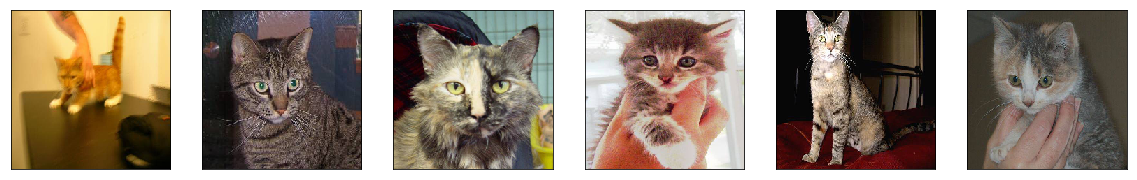

In [18]:
# 展示6张图片
fig = plt.figure(figsize=(20,5))
for i in range(6):
    ax = fig.add_subplot(1, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(train_mode[i]/256))

## 使用迁移学习

使用预训练的基于模型作为固定的图像特征提取器

封装图像特征提取器到函数内

In [ ]:
def Image_feature_extractor(input_model, preprocess_input, train_mode, valid_mode, test_mode):
    # 建立预训练的模型
    base_model = input_model(weights='imagenet', include_top=False)
    # # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # 创建新的model
    model = Model(input=base_model.input, output=x)
    
    # 归一化数据等预处理数据
    train_mode_pre = preprocess_input(train_mode)
    valid_mode_pre = preprocess_input(valid_mode)
    test_mode_pre = preprocess_input(test_mode)
    
    # 提取特征向量
    train = model.predict(train_mode_pre)
    valid = model.predict(valid_mode_pre)
    test = model.predict(test_mode_pre)
    train_target = train_targets
    valid_target = valid_targets
    #为了后续使用test_name,所以此次将test_files出入npz文件中
    test_files_name = test_files

    # 概览模型
#     model.summary()

    # print resule
    print('There are %d training images.' % len(train))
    print('There are %d validation images.' % len(valid))
    print('There are %d test images.'% len(test))
    
    # 将提取的特征向量存入文件
    np.savez("data/pre_data/cat_dog_%s.npz"%input_model.__name__, train = train, valid = valid, test = test, train_target = train_target, valid_target = valid_target, test_files_name = test_files_name)

In [ ]:
# 基于ResNet50 提取特征向量
Image_feature_extractor(ResNet50, preprocess_input_ResNet50, train_mode, valid_mode, test_mode)

C:\Users\zb\Anaconda3\envs\dog-project\lib\site-packages\ipykernel\__main__.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("gl..., inputs=Tensor("in...)`


In [ ]:
# 基于Xception 提取特征向量
Image_feature_extractor(Xception, preprocess_input_Xception, train_mode, valid_mode, test_mode)

In [ ]:
# 基于InceptionV3提取特征向量
Image_feature_extractor(InceptionV3, preprocess_input_InceptionV3, train_mode, valid_mode, test_mode)

## 生成训练数据
根据特征向量提取器预处理的数据，形成训练、验证和测试数据

In [ ]:
#加载预处理的数据进行拼接，建立训练、验证、测试数据集
X_train = []
X_valid = []
X_test = []

y_train = []
y_valid = []

#加载预处理的数据
for filename in ['data/pre_data\\cat_dog_InceptionV3.npz', 'data/pre_data\\cat_dog_ResNet50.npz', 'data/pre_data\\cat_dog_Xception.npz']:
    mid = np.load(filename)
    X_train.append(mid['train'])
    X_valid.append(mid['valid'])
    X_test.append(mid['test'])
    test_files_name = mid['test_files_name']
    
    y_train = mid['train_target']
    y_valid = mid['valid_target']

# 按照行的方向拼接数据
X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)
X_valid = np.concatenate(X_valid, axis=1)

In [ ]:
# 查看预处理数据输出的属性
X_train.shape

## 创建图像增强

In [ ]:
# # 图像增强
# datagen_X_train = ImageDataGenerator(
#     width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
#     height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
#     horizontal_flip=True) # randomly flip images horizontally

# # fit augmented image generator on data
# datagen_X_train.fit(X_train)

## 创建模型

In [ ]:
# 建立CNN模型
model = Sequential()
model.add(Dense(X_train.shape[1], input_shape=X_train.shape[1:]))
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))
# 模型概括
model.summary()

## 训练模型

In [ ]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
                  metrics=['accuracy'])

In [ ]:
# # 测试，非正式数据
# from keras.layers import Input
# input_tensor = Input(X_train.shape[1:])
# x = Dropout(0.5)(input_tensor)
# x = Dense(2, activation='sigmoid')(x)
# model = Model(input_tensor, x)
# model.compile(optimizer='adadelta',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])
# model.summary()

In [ ]:
# #训练模型
# batch_size = 32
# epochs = 5

# # train the model
# checkpointer = ModelCheckpoint(filepath='data/model.weights.best.hdf5', verbose=1, 
#                                save_best_only=True)
# model.fit_generator(datagen_X_train.flow(X_train, y_train, batch_size=batch_size),
#                     steps_per_epoch=X_train.shape[0] // batch_size,
#                     epochs=epochs, verbose=2, callbacks=[checkpointer],
#                     validation_data=(X_valid, y_valid),
#                     validation_steps=X_valid.shape[0] // batch_size)

In [ ]:
#训练模型
epochs = 3

checkpointer = ModelCheckpoint(filepath='data/model.weights.best.hdf5', 
                               verbose=1, save_best_only=True)

model_history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

In [ ]:
# 加载最优模型
model.load_weights('data/model.weights.best.hdf5')

## 预测测试集

In [ ]:
# 预测test中的结果
test_targets = model.predict(X_test)

In [ ]:
# 创建label
# label的值越接近1表示cat，越接近0表示dog
label = []
for test_target in test_targets:
    if np.argmax(test_target) == 0:
        label.append(test_target[0])
    elif np.argmax(test_target) == 1:
        label.append(1 - test_target[1])
    else:
        print('err')

In [ ]:
#创建ID
num = []
for test_name in test_files_name:
    num.append(re.sub("\D", "",test_name[10:]))

## 按照要求生成sample_submission.csv文件

In [ ]:
#字典中的key值即为csv中列名
sample_submission = pd.DataFrame({'Id':num,'label':label})
#将DataFrame存储为csv,index表示是否显示行名，default=True
sample_submission.to_csv('data/sample_submission.csv',index=False,sep=',')

In [ ]:
pd.read_csv('data/sample_submission.csv')

## 可视化训练过程

In [ ]:
%matplotlib inline
# 可视化
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.legend(["acc", "val_acc"], loc='best')
    plt.title('Training and validation accuracy')
    plt.figure()

    loss = history.history['loss']
    val_loss = history.history['val_loss']   
    plt.plot(epochs, loss, 'b')
    plt.plot(epochs, val_loss, 'r')
    plt.legend(["loss", "val_loss"], loc='best')
    plt.title('Training and validation loss')
    plt.show()

# 训练的acc_loss图
plot_training(model_history)